In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
import numpy as np
import os
from utils import peek
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import missingno as msno
import seaborn as sns
import config
import pickle

In [2]:
def calc_iv(matrix, feature, target, pr=False):
    df = matrix.copy()
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Distribution Good'] = (data['Good'] + 1) / data['Good'].sum()
    data['Distribution Bad'] = (data['Bad'] + 1) / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    data['IV'] = (data['Distribution Good'] - data['Distribution Bad']) * data['WoE']

    if pr:
        print(data.sort_values('Value'))
        print('IV = ', round(data['IV'].sum(), 6))

    return round(data['IV'].sum(), 6)

1w个样本中，正负样本的比例为3:7

In [3]:
data = pd.read_csv(config.DATA, header = [0, 1], low_memory=False)
order_status_map = {2:1}
data[('sample', 'order_status_key')] = data[('sample', 'order_status_key')].map(order_status_map).fillna(0)
data[('sample', 'order_status_key')].value_counts()

0.0    7231
1.0    2816
Name: (sample, order_status_key), dtype: int64

## 百融多头
虽然有较好的区分效果，但是只覆盖了80%的客户。尽管如此，没覆盖到的客户批核率很高，有38%。

In [4]:
br_duotou = data[['sample', 'br_duotou']]
br_duotou.columns = br_duotou.columns.get_level_values(1)
br_duotou_retrieved = br_duotou['flag_applyloanstr'].sum()
print("百融多头查得样本数: ", br_duotou_retrieved)
print("占比: ", br_duotou_retrieved / data.shape[0])

百融多头查得样本数:  8033
占比:  0.7995421518861352


In [5]:
br_duotou_retrieved_fail = br_duotou[br_duotou['flag_applyloanstr'] != 1]
fail_appr_rate = br_duotou_retrieved_fail['order_status_key'].sum() / br_duotou_retrieved_fail.shape[0]
print("百融多头查不到的样本的核卡率: ", fail_appr_rate)

百融多头查不到的样本的核卡率:  0.3728897715988083


### 计算百融多头特征iv

In [6]:
br_duotou_id = br_duotou.query('flag_applyloanstr == 1').filter(regex="^(?!.*cell)") #只使用身份证查得的数据
interval_feats = br_duotou_id.filter(regex="inteday").columns
br_duotou_id[interval_feats] = br_duotou_id[interval_feats].fillna(9999)
br_duotou_id = br_duotou_id.fillna(0)

In [7]:
def binning(series):
    percentiles = list(range(0, 101, 10))
    val = np.percentile(series, percentiles).tolist()
    if max(series) != 9999:
        bins = list(sorted(set([min(val) - 1] + val)))
    else:
        bins = list(sorted(set( [min(val) - 1] + val + [9998, 9999])))
    series_bin = pd.cut(series, bins, labels=list(range(len(bins) - 1))).astype("int")
    return series_bin
    
features = br_duotou_id.iloc[:, 4:].columns
br_duotou_id_bin = br_duotou_id.copy()
br_duotou_id_bin[features] = br_duotou_id_bin[features].apply(binning)

In [8]:
feature_iv = []
for feature in features:
    feature_iv.append([feature, calc_iv(br_duotou_id_bin, feature, 'order_status_key')])
feature_iv = pd.DataFrame(feature_iv, columns = ['feature', 'iv']).sort_values('iv', ascending=False)

In [9]:
iv_threshold = 0.02
qualified_features = feature_iv.query(f'iv > {iv_threshold}').reset_index(drop=True)
cursor = -1

discard_features = []
while abs(cursor) < qualified_features.shape[0]:
    print('number of discard features: ', len(discard_features))
    X = add_constant(br_duotou_id[filter(lambda x: x not in discard_features, qualified_features['feature'])])
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).rename('vif')
    qualified_features = qualified_features.drop(columns=['vif'], errors='ignore').merge(vif, left_on='feature', right_index=True, how="inner")
    feature, iv, vif_val = qualified_features.iloc[cursor, :].values
    if vif_val < 4:
        cursor = cursor - 1
    else:
        discard_features.append(feature)

number of discard features:  0


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  1


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  1


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  2


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  2


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  2


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  3


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  4


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  5


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  6


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  7


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  7


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  8


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  9


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  10


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  11


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  12


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  12


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  13


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  14


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  14


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  15


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  16


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  17


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  18


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  19


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  20


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  21


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  22


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  23


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  24


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  25


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  26


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  27


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  28


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  29


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  30


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  31


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  32


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  33


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  34


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  35


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  36


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  36


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  36


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  37


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  38


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  39


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  40


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  41


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  42


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  43


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  43


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  44


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  45


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  46


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  46


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  47


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  48


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  49


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  50


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  51


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  52


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  53


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  54


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  55


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  56


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  57


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  58


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  59


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  60


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  61


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  62


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  63


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  64


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  65


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  66


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  67


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  68


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  69


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  70


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  71


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  72


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  73


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  74


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  75


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  75


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  76


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  77


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  78


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  78


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  79


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  80


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  81


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  82


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  83


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  84


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  85


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  86


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  87


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  88


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  89


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  90


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  91


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  92


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  93


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  94


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  95


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  95


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  96


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  97


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  98


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  99


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  100


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  101


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  102


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  103


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  104


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  105


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  106


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  107


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  108


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  109


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  110


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  111


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  112


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  113


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  114


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  115


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  116


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  117


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  118


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  119


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  120


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  121


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  122


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  123


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  123


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  124


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  125


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  126


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  127


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  128


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  129


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  130


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  131


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  132


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  133


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  134


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  135


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  136


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  137


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  138


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  139


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  140


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  141


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  142


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  143


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  144


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  145


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  146


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  147


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  148


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  149


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  150


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  151


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  152


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  153


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  154


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  155


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  156


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  157


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  158


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  159


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  160


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  161


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  162


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  163


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  164


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  165


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  166


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  167


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  168


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  169


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  170


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  171


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  172


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  173


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  174


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  174


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  175


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  176


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  177


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  178


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  179


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  180


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  181


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  182


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  182


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  183


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  184


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  185


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  186


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  187


/sda/software/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


number of discard features:  188
number of discard features:  189
number of discard features:  190
number of discard features:  191
number of discard features:  192
number of discard features:  193
number of discard features:  194
number of discard features:  195
number of discard features:  196
number of discard features:  197
number of discard features:  197
number of discard features:  198
number of discard features:  199
number of discard features:  199
number of discard features:  200
number of discard features:  201
number of discard features:  202
number of discard features:  203
number of discard features:  204
number of discard features:  205
number of discard features:  206
number of discard features:  207
number of discard features:  208
number of discard features:  209
number of discard features:  210
number of discard features:  211
number of discard features:  212
number of discard features:  213
number of discard features:  214
number of discard features:  215
number of 

In [10]:
qualified_features = qualified_features.reset_index(drop=True)
br_duotou_qualified_features = qualified_features.copy()

In [22]:
br_duotou_qualified_features

,feature,iv,vif
0,als_m12_id_nbank_orgnum,1.315481,4.340915
1,als_m3_id_nbank_min_inteday,1.030968,1.888262
2,als_m12_id_nbank_min_inteday,0.988303,2.857176
3,als_m12_id_min_inteday,0.813420,1.922801
4,als_lst_id_nbank_inteday,0.504349,1.746055
5,als_m12_id_rel_orgnum,0.501569,2.508075
6,als_m12_id_cooff_orgnum,0.422419,2.116554
7,als_m12_id_nbank_night_orgnum,0.346511,2.065256
8,als_m12_id_bank_ret_orgnum,0.341991,1.838720
9,als_lst_id_nbank_consnum,0.289215,1.384507


对于iv最高的特征als_m12_id_nbank_orgnum（近12个月非银机构申请机构数），可以在几乎不影响召回率的情况下把样本划分为两个客群

In [11]:
# 近12个月非银机构申请机构数（去重）
feat = r'als_m12_id_nbank_orgnum'

thresholds = list(range(1, 16))
matrix_orgnum = br_duotou_id[['order_status_key',  feat]]
result = []
for t in thresholds:
    bt = matrix_orgnum[matrix_orgnum[feat] <= t]
    filter_rate = np.round(1 - bt.shape[0] / matrix_orgnum.shape[0], 4)
    recall = np.round(bt['order_status_key'].sum() / matrix_orgnum['order_status_key'].sum(), 4)
    appr_rate = np.round(bt['order_status_key'].sum() / bt.shape[0], 4)
    result.append([t, filter_rate, recall, appr_rate])
result = pd.DataFrame(result, columns = ['ae_m12_id_nbank_orgnum_d_threshold', 'filter_rate', 'recall', 'appr_rate'])
result

,ae_m12_id_nbank_orgnum_d_threshold,filter_rate,recall,appr_rate
0,1,0.6299,0.6077,0.4221
1,2,0.4828,0.8092,0.4022
2,3,0.3890,0.9056,0.3810
3,4,0.3237,0.9477,0.3602
4,5,0.2761,0.9719,0.3451
5,6,0.2436,0.9811,0.3334
6,7,0.2166,0.9864,0.3237
7,8,0.1937,0.9913,0.3160
8,9,0.1769,0.9952,0.3108
9,10,0.1625,0.9956,0.3056


## 百融黑名单
没有通过黑名单的客户占3.5%左右，而且基本不能通过银行审核，而且免费，可以用作规则

In [12]:
br_black_list = data[['sample', 'br_black_list']]
br_black_list.columns = br_black_list.columns.get_level_values(1)
br_in_black_list = br_black_list['flag_specialList_c'].sum()
print("黑名单占比: ", br_in_black_list / data.shape[0])

黑名单占比:  0.03404001194386384


In [13]:
br_black_list[br_black_list['flag_specialList_c'] == 1]['order_status_key'].sum()

9.0

## 百融偿债压力指数
在偿债压力较高的用户群里（前20%），区分度较高，但是在剩下的客群里区分度不高

In [14]:
br_debt_pressure = data[['sample', 'br_debt_pressure']]
br_debt_pressure.columns = br_debt_pressure.columns.get_level_values(1)
br_debt_pressure_retrieved = br_debt_pressure.query('flag_debtrepaystress == 1')
print("查得样本占比: ", br_debt_pressure_retrieved.shape[0] / br_debt_pressure.shape[0])

查得样本占比:  0.9586941375534985


In [15]:
br_debt_pressure_bin = br_debt_pressure_retrieved.copy()
br_debt_pressure_bin['drs_nodebtscore'] = MinMaxScaler().fit_transform(br_debt_pressure_bin[['drs_nodebtscore']])
br_debt_pressure_bin['drs_nodebtscore'] = br_debt_pressure_bin[['drs_nodebtscore']].apply(binning)
calc_iv(br_debt_pressure_bin, 'drs_nodebtscore', 'order_status_key', True)

           Variable  Value   All  Good  Bad  Distribution Good  \
10  drs_nodebtscore      0     1     1    0           0.000732   
1   drs_nodebtscore      1  1329   614  715           0.225110   
3   drs_nodebtscore      2  1149   467  682           0.171303   
4   drs_nodebtscore      3   804   296  508           0.108712   
2   drs_nodebtscore      4  1418   498  920           0.182650   
5   drs_nodebtscore      5   589   213  376           0.078331   
7   drs_nodebtscore      6  1026   285  741           0.104685   
8   drs_nodebtscore      7   529   124  405           0.045754   
0   drs_nodebtscore      8   868   153  715           0.056369   
9   drs_nodebtscore      9   980    67  913           0.024890   
6   drs_nodebtscore     10   939    14  925           0.005490   

    Distribution Bad       WoE        IV  
10          0.000145  1.619635  0.000951  
1           0.103768  0.774430  0.093971  
3           0.098986  0.548461  0.039663  
4           0.073768  0.387772  0.0

0.795639

## 百融法院被执行人
法院被执行人能够过滤3%的客户，但是因为收费，所以不考虑使用

In [16]:
br_execution = data[['sample', 'br_execution']]
br_execution.columns = br_execution.columns.get_level_values(1)
retrieved = br_execution['flag_executionpro'].sum()
print("查得占比: ", retrieved / br_execution.shape[0])

查得占比:  0.03473673733452772


## 百融停机次数
只有23条数据可以验证，无法评估有效性

In [17]:
br_cell_disconnect = data[['sample', 'br_cell_disconnect']]
br_cell_disconnect.columns = br_cell_disconnect.columns.get_level_values(1)
retrieved = br_cell_disconnect['flag_teldownnum'].sum()
print(retrieved)

23.0


## 百融在网时长
只有26条数据可以验证，无法评估有效性

In [18]:
br_cell_length = data[['sample', 'br_cell_length']]
br_cell_length.columns = br_cell_length.columns.get_level_values(1)
retrieved = br_cell_length['flag_telperiod'].sum()
print(retrieved)

26.0


## 百融在网状态（不用）
只有26条数据可以验证，无法评估有效性

In [19]:
br_cell_status = data[['sample', 'br_cell_status']]
br_cell_status.columns = br_cell_status.columns.get_level_values(1)
retrieved = br_cell_status['flag_telstatus'].sum()
print(retrieved)

26.0


## 腾讯反欺诈
反欺诈数据覆盖程度较高，IV也挺高，但是相对于百融多头来说召回率没那么高

In [29]:
tencent_fraud_risk = data[['sample', 'tc_fraud_risk']]
tencent_fraud_risk.columns = tencent_fraud_risk.columns.get_level_values(1)
tencent_fraud_risk = tencent_fraud_risk.drop(columns=['id_found:', 'found:', 'risk_code:'])

In [31]:
features = tencent_fraud_risk.iloc[:, 3:].columns
tencent_fraud_risk = tencent_fraud_risk.dropna(subset=['highirr_v6_20220425_score'])
tencent_fraud_risk_bin = tencent_fraud_risk.copy()
tencent_fraud_risk_bin[features] = MinMaxScaler().fit_transform(tencent_fraud_risk_bin[features])
tencent_fraud_risk_bin[features] = tencent_fraud_risk_bin[features].apply(binning)

In [32]:
feature_iv = []
for feature in features:
    feature_iv.append([feature, calc_iv(tencent_fraud_risk_bin, feature, 'order_status_key')])
feature_iv = pd.DataFrame(feature_iv, columns = ['feature', 'iv']).sort_values('iv', ascending=False)
feature_iv

,feature,iv
6,model_risk_v7_stongyong_score,0.926523
5,model_risk_v7_slowirr_score,0.854736
2,lowirr_v6_20220425_score,0.787051
4,model_risk_v7_shighirr_score,0.767500
3,tongyong_v6_20220425_score,0.723072
1,highirr_v6_20220425_score,0.658863
0,risk_score:,0.504523
7,v6_seq_online,0.330441


In [33]:
discard_features = ['highirr_v6_20220425_score', 'tongyong_v6_20220425_score', 'model_risk_v7_shighirr_score', 'model_risk_v7_slowirr_score', 'lowirr_v6_20220425_score']
X = add_constant(tencent_fraud_risk[filter(lambda x: x not in discard_features, features)])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns).rename('vif')
vif

const                            13.792263
risk_score:                       1.823339
model_risk_v7_stongyong_score     2.118700
v6_seq_online                     1.417448
Name: vif, dtype: float64

## 腾讯多头
从评估结果上看，百融多头会比腾讯多头好些

In [34]:
tc_duotou = data[['sample', 'tc_duotou']]
tc_duotou.columns = tc_duotou.columns.get_level_values(1)

<AxesSubplot:>

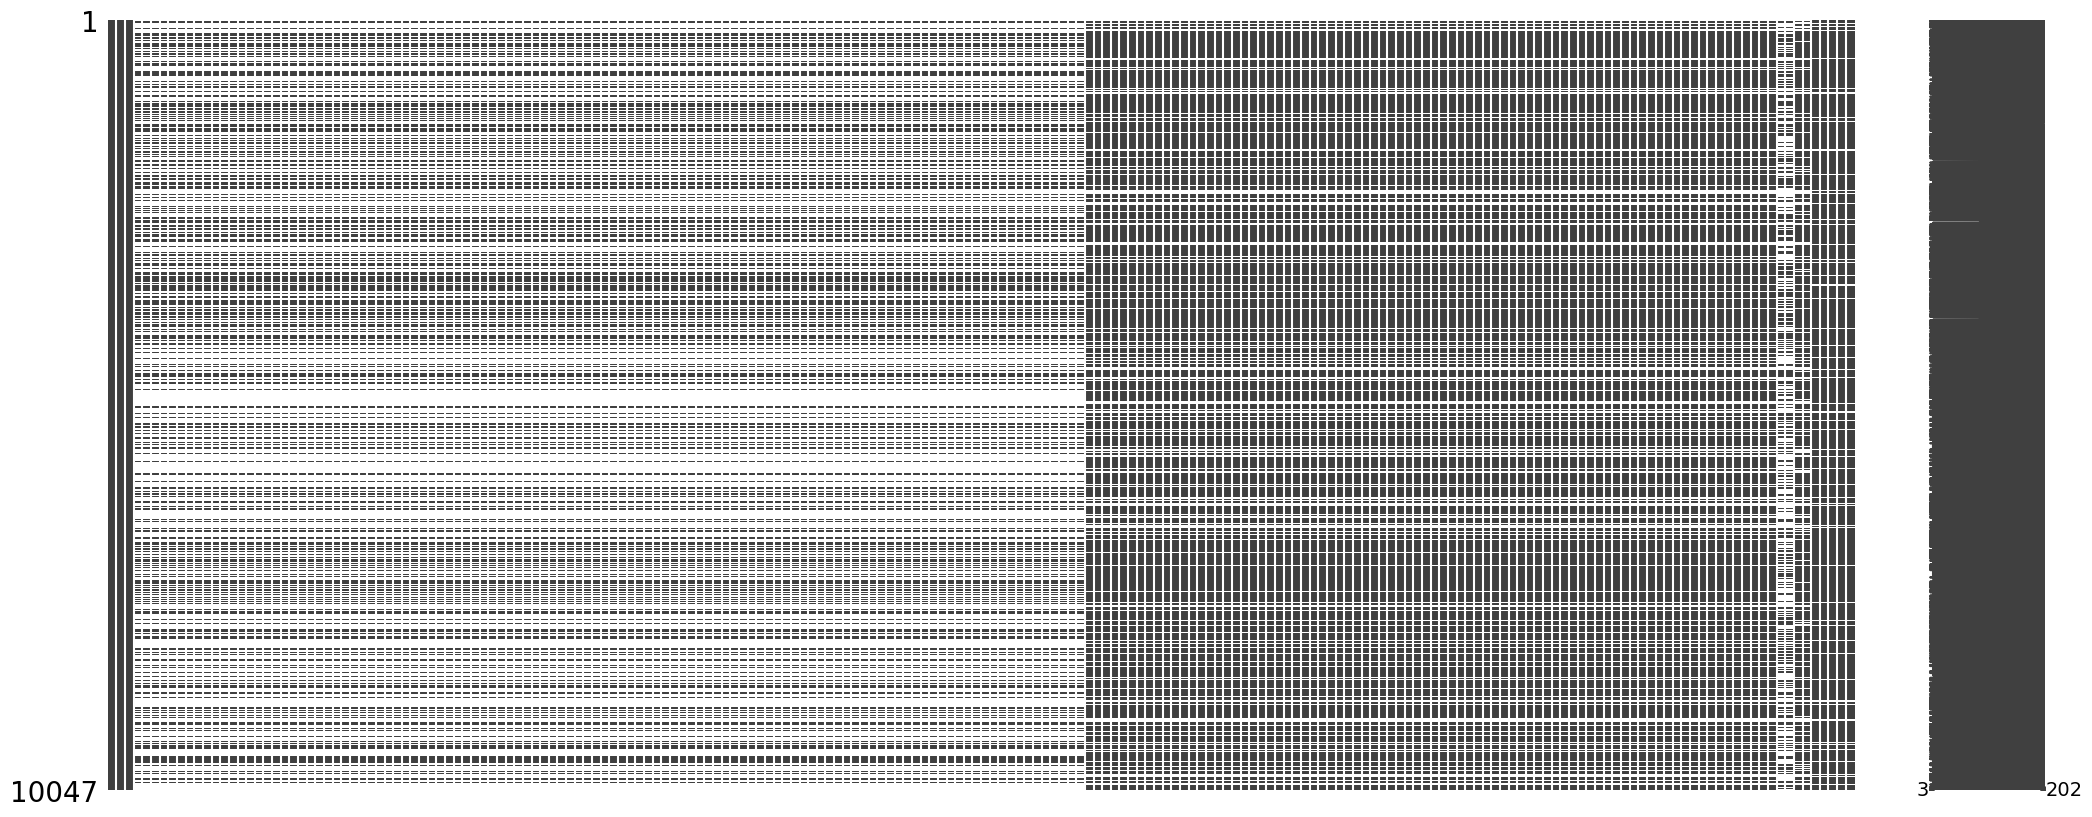

In [35]:
msno.matrix(tc_duotou)

In [36]:
# 只使用空值较少的列
keep_features = list(filter(lambda x: sum(tc_duotou[x].isna().values == False) > 5000, tc_duotou.columns))
len(keep_features)

90

腾讯多头只有一半的特征覆盖率达80%以上

In [37]:
tc_duotou[keep_features].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10047 entries, 0 to 10046
Data columns (total 90 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_phone      10047 non-null  object 
 1   apply_date_key      10047 non-null  object 
 2   order_status_key    10047 non-null  float64
 3   180天内总申请次数          8228 non-null   float64
 4   180天内银行申请次数         8228 non-null   float64
 5   180天内持牌消金申请次数       8228 non-null   float64
 6   180天内互金申请次数         8228 non-null   float64
 7   180天内金融科技申请次数       8228 non-null   float64
 8   180天内其他申请次数         8228 non-null   float64
 9   360天内总申请次数          8228 non-null   float64
 10  360天内银行申请次数         8228 non-null   float64
 11  360天内持牌消金申请次数       8228 non-null   float64
 12  360天内互金申请次数         8228 non-null   float64
 13  360天内金融科技申请次数       8228 non-null   float64
 14  360天内其他申请次数         8228 non-null   float64
 15  720天内总申请次数          8228 non-null   float64
 16  720天

In [38]:
tc_duotou = tc_duotou[keep_features]

In [39]:
tc_duotou_bin = tc_duotou.copy()
apply_count = tc_duotou_bin.filter(regex="\d+天|order_status_key").dropna(subset="30天相对过去720天新增银行平台数")
apply_count.iloc[:, 1:] = apply_count.iloc[:, 1:].apply(binning)

In [40]:
feature_iv = []
for f in apply_count.columns.difference(['order_status_key']):
    feature_iv.append([f, calc_iv(apply_count, f, 'order_status_key')])
feature_iv = pd.DataFrame(feature_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)
feature_iv

,feature,iv
20,180天总申请白天平台数,0.995927
10,180天内总申请平台数,0.984277
36,360天内总申请平台数,0.970329
72,7天相对过去180天新增总平台数,0.926409
46,360天总申请白天平台数,0.923856
74,7天相对过去360天新增总平台数,0.882045
56,720天内总申请平台数,0.875220
66,720天总申请白天平台数,0.865227
2,15天相对过去360天新增总平台数,0.853127
76,7天相对过去720天新增总平台数,0.850185


In [41]:
apply_inte = tc_duotou_bin[['最早一次在非银机构距今的天数', '最近一次在非银机构距今的天数', 'order_status_key']].dropna(subset="最早一次在非银机构距今的天数")
apply_inte.iloc[:, :-1] = apply_inte.iloc[:, :-1].apply(binning)

In [42]:
feature_iv = []
for f in apply_inte.columns.difference(['order_status_key']):
    feature_iv.append([f, calc_iv(apply_inte, f, 'order_status_key')])
feature_iv = pd.DataFrame(feature_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)
feature_iv

,feature,iv
1,最近一次在非银机构距今的天数,0.324254
0,最早一次在非银机构距今的天数,0.064857


In [43]:
apply_score = tc_duotou_bin.filter(regex="申请分|order_status").dropna(subset="非银多头申请分")
apply_score.iloc[:, 1:] = MinMaxScaler().fit_transform(apply_score.iloc[:, 1:])
apply_score.iloc[:, 1:] = apply_score.iloc[:, 1:].apply(binning)

In [44]:
feature_iv = []
for f in apply_score.columns.difference(['order_status_key']):
    feature_iv.append([f, calc_iv(apply_score, f, 'order_status_key')])
feature_iv = pd.DataFrame(feature_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)
feature_iv

,feature,iv
0,短周期多头申请分,0.720474
3,非银多头申请分,0.506807
1,银行多头申请分,0.408525
2,长周期多头申请分,0.349152


## 腾讯逾期
覆盖客户少，而且有逾期记录的客户中，无法有效区分出高质量客户

In [45]:
tc_overdue = data[['sample', 'tc_overdue']]
tc_overdue.columns = tc_overdue.columns.get_level_values(1)

<AxesSubplot:>

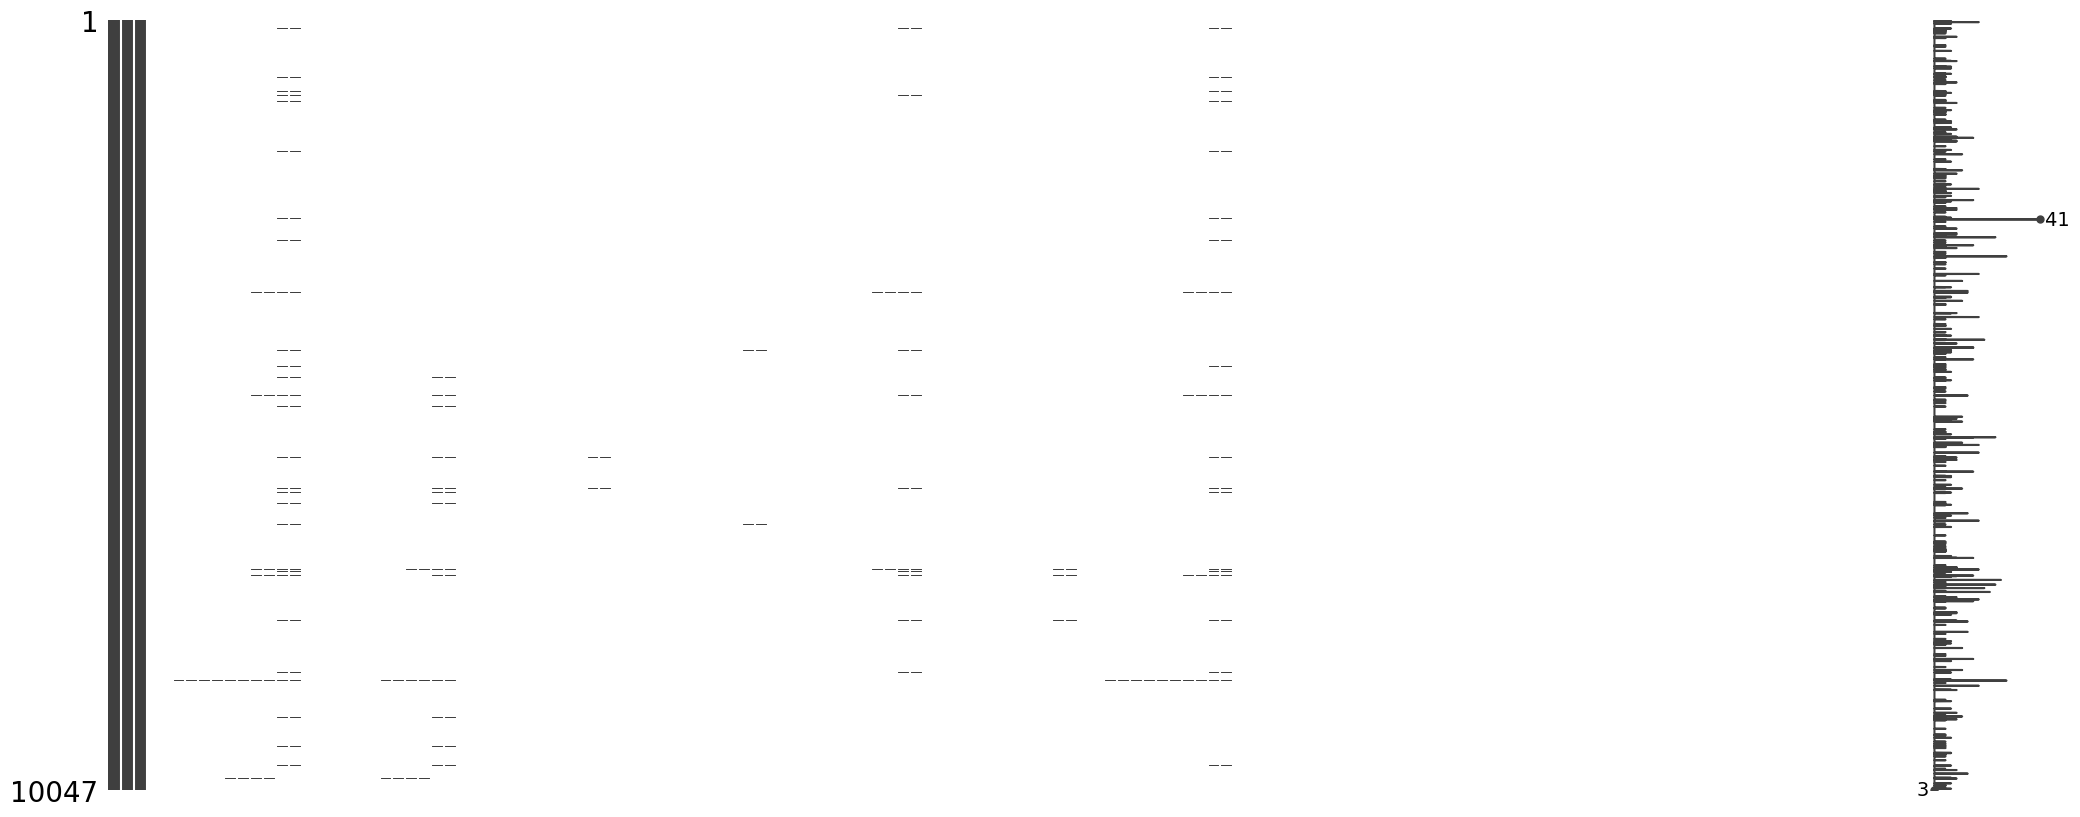

In [46]:
msno.matrix(tc_overdue)

In [47]:
tc_overdue = tc_overdue.fillna(0)
tc_overdue['have_record'] = tc_overdue.iloc[:, 3:].sum(axis=1) > 0

In [48]:
tc_overdue.query('have_record == 1')['order_status_key'].value_counts()

0.0    297
1.0     97
Name: order_status_key, dtype: int64

## 腾讯圈团&可疑&电诈
没什么用

In [49]:
tc_risk = data[['sample', 'tc_risk']]
tc_risk.columns = tc_risk.columns.get_level_values(1)

In [50]:
tc_risk['疑似被电诈V3（92006）'] = np.nan

/tmp/ipykernel_189066/1877764883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc_risk['疑似被电诈V3（92006）'] = np.nan


In [51]:
keep_features = list(filter(lambda x: sum(tc_risk[x].isna().values) < 2000, tc_risk.columns))
tc_risk = tc_risk[keep_features].dropna()
peek(tc_risk, 2)

(9111, 5)
                     customer_phone apply_date_key  order_status_key  \
1  057331edd64b9002ddfc084e2d09b441     2023-03-25               1.0   
2  2d84b1d936cfc398062267ae3c88ba5e     2023-03-22               1.0   

   圈团1迭代浓度分V2(21007)  圈团3浓度分V1（23006）  
1               45.0             26.0  
2               37.0             26.0  


In [52]:
tc_risk.iloc[:, 3:] = MinMaxScaler().fit_transform(tc_risk.iloc[:, 3:])
tc_risk.iloc[:, 3:] = tc_risk.iloc[:, 3:].apply(binning)

In [53]:
for c in tc_risk.iloc[:, 3:].columns:
    print(c, "iv: ", calc_iv(tc_risk, c, 'order_status_key', False))

圈团1迭代浓度分V2(21007) iv:  0.070432
圈团3浓度分V1（23006） iv:  0.048504


## 尚为逾期
效果一般

In [54]:
sw_overdue = data[['sample', 'sw_overdue']]
sw_overdue.columns = sw_overdue.columns.get_level_values(1)
sw_overdue = sw_overdue.query("y == 'y'").drop('y', axis=1)

<AxesSubplot:>

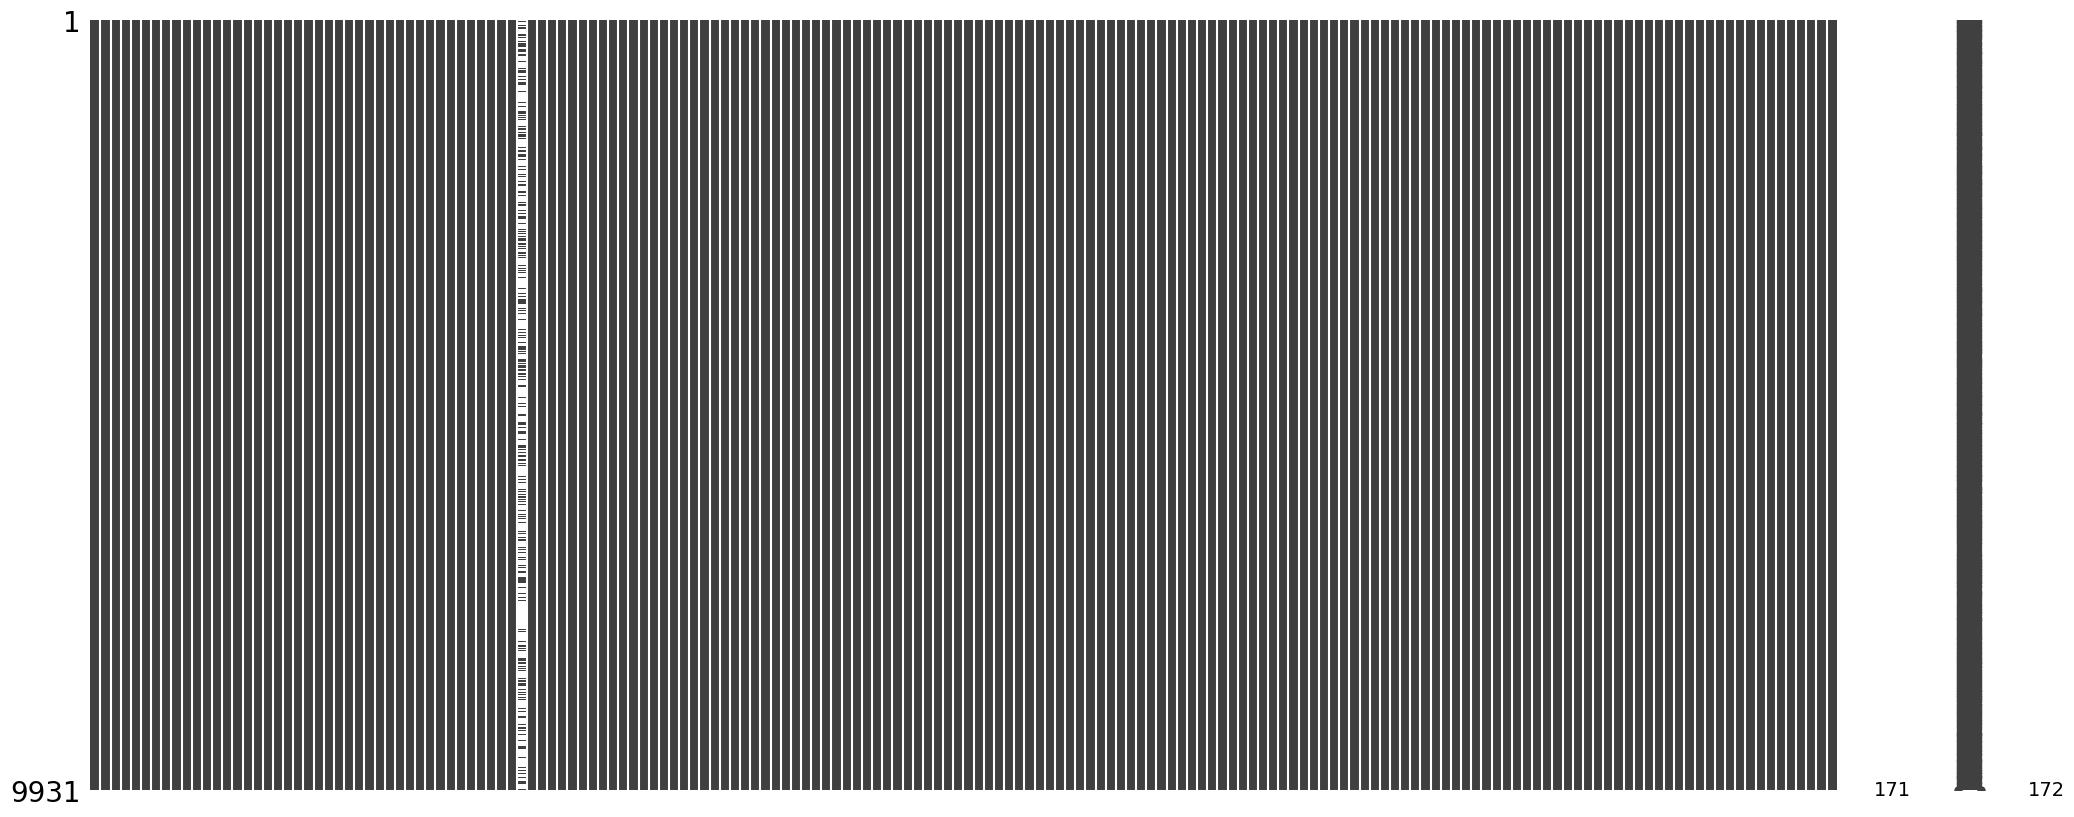

In [55]:
msno.matrix(sw_overdue)

In [56]:
keep_features = list(filter(lambda x: sum(sw_overdue[x].isna().values) < 2000, sw_overdue.columns))
sw_overdue = sw_overdue[keep_features].dropna()

In [57]:
sw_overdue.iloc[:, 3:] = sw_overdue.iloc[:, 3:].apply(binning)
feature_iv = []
for f in sw_overdue.iloc[:, 3:].columns:
    feature_iv.append([f, calc_iv(sw_overdue, f, 'order_status_key', False)])
feature_iv = pd.DataFrame(feature_iv, columns=['features', 'iv']).sort_values('iv', ascending=False)

In [58]:
feature_iv

,features,iv
7,overdue_risk_ifin_loan_slight_plat_cnt_720d,0.237755
88,overdue_risk_ifin_loan_slight_cnt_720d,0.228164
36,overdue_risk_all_slight_plat_cnt_720d,0.200126
28,overdue_risk_all_slight_cnt_720d,0.177693
100,overdue_risk_all_serious_cnt_720d,0.164392
...,...,...
64,overdue_risk_credit_slight_plat_cnt_180d,0.059911
65,overdue_risk_credit_serious_cnt_60d,0.059911
66,overdue_risk_all_general_cnt_90d,0.059911
67,overdue_risk_all_serious_plat_cnt_360d,0.059911


## 尚为还款能力
效果一般

In [59]:
shangwei_repay = data[['sample', 'sw_repayability']]
shangwei_repay.columns = shangwei_repay.columns.get_level_values(1)
shangwei_repay = shangwei_repay.query("y == 'y'").drop(["y"], axis=1)

In [60]:
calc_iv(shangwei_repay, 'repayabilitymodelv3', 'order_status_key', True)

              Variable Value   All  Good   Bad  Distribution Good  \
4  repayabilitymodelv3     A   550    89   461           0.031960   
0  repayabilitymodelv3     B  3146   591  2555           0.210227   
3  repayabilitymodelv3     C  4719  1556  3163           0.552912   
2  repayabilitymodelv3     D  1366   465   901           0.165483   
1  repayabilitymodelv3     E   266   115   151           0.041193   

   Distribution Bad       WoE        IV  
4          0.063892 -0.692695  0.022119  
0          0.353478 -0.519632  0.074438  
3          0.437561  0.233984  0.026990  
2          0.124741  0.282631  0.011515  
1          0.021021  0.672770  0.013571  
IV =  0.148633


0.148633

## 尚为收入指数
效果一般

In [61]:
shangwei_income = data[['sample', 'sw_income']]
shangwei_income.columns = shangwei_income.columns.get_level_values(1)
shangwei_income = shangwei_income.query("y == 'y'").drop(["y"], axis=1)

In [62]:
calc_iv(shangwei_income, 'incomelevelmodelv5', 'order_status_key', True)

             Variable Value   All  Good   Bad  Distribution Good  \
0  incomelevelmodelv5     A  5669  1303  4366           0.647789   
1  incomelevelmodelv5     B  1168   363   805           0.180825   
3  incomelevelmodelv5     C   426   144   282           0.072032   
5  incomelevelmodelv5     D   153    68    85           0.034277   
4  incomelevelmodelv5     E   138    53    85           0.026826   
2  incomelevelmodelv5     F   188    82   106           0.041232   

   Distribution Bad       WoE        IV  
0          0.762262 -0.162725  0.018628  
1          0.140688  0.250985  0.010074  
3          0.049398  0.377202  0.008538  
5          0.015011  0.825674  0.015907  
4          0.015011  0.580552  0.006859  
2          0.018677  0.791927  0.017862  
IV =  0.077867


0.077867

## 尚为履约能力
效果一般

In [63]:
shangwei_contract = data[['sample', 'sw_contract']]
shangwei_contract.columns = shangwei_contract.columns.get_level_values(1)
shangwei_contract = shangwei_contract.query("y == 'y'").drop(["y"], axis=1)

In [64]:
shangwei_contract = shangwei_contract.copy()
shangwei_contract['performance_capacity_score_v3'] = MinMaxScaler().fit_transform(shangwei_contract[['performance_capacity_score_v3']])
shangwei_contract['performance_capacity_score_v3'] = shangwei_contract[['performance_capacity_score_v3']].apply(binning)
calc_iv(shangwei_contract, 'performance_capacity_score_v3', 'order_status_key', True)

                         Variable  Value   All  Good   Bad  Distribution Good  \
10  performance_capacity_score_v3      0     1     0     1           0.000355   
2   performance_capacity_score_v3      1  1027   266   761           0.094815   
3   performance_capacity_score_v3      2   982   236   746           0.084162   
0   performance_capacity_score_v3      3  1735   288  1447           0.102628   
6   performance_capacity_score_v3      4   275    87   188           0.031250   
4   performance_capacity_score_v3      5  1033   250   783           0.089134   
7   performance_capacity_score_v3      6   975   285   690           0.101562   
5   performance_capacity_score_v3      7  1007   400   607           0.142401   
8   performance_capacity_score_v3      8  1032   345   687           0.122869   
1   performance_capacity_score_v3      9  1723   567  1156           0.201705   
9   performance_capacity_score_v3     10   257    92   165           0.033026   

    Distribution Bad       

0.126504

## 尚为综合信用评估
覆盖率高，区分能力强

In [65]:
shangwei_credit = data[['sample', 'sw_credit_eval']]
shangwei_credit.columns = shangwei_credit.columns.get_level_values(1)
shangwei_credit = shangwei_credit.query("y == 'y'").drop('y', axis=1)

In [66]:
shangwei_credit_bin = shangwei_credit.copy()
shangwei_credit_bin['omriskscoregeneral'] = MinMaxScaler().fit_transform(shangwei_credit[['omriskscoregeneral']])
shangwei_credit_bin['omriskscoregeneral'] = shangwei_credit_bin[['omriskscoregeneral']].apply(binning)
calc_iv(shangwei_credit_bin, 'omriskscoregeneral', 'order_status_key', True)

              Variable  Value   All  Good  Bad  Distribution Good  \
10  omriskscoregeneral      0     2     0    2           0.000355   
0   omriskscoregeneral      1  1011    25  986           0.009243   
8   omriskscoregeneral      2  1026   100  926           0.035905   
7   omriskscoregeneral      3   986   152  834           0.054390   
5   omriskscoregeneral      4  1000   178  822           0.063633   
9   omriskscoregeneral      5   984   234  750           0.083541   
1   omriskscoregeneral      6  1032   307  725           0.109492   
4   omriskscoregeneral      7   990   383  607           0.136509   
6   omriskscoregeneral      8   991   408  583           0.145396   
3   omriskscoregeneral      9  1001   461  540           0.164237   
2   omriskscoregeneral     10   992   565  427           0.201209   

    Distribution Bad       WoE        IV  
10          0.000417 -0.158505  0.000010  
0           0.137045 -2.696466  0.344615  
8           0.128714 -1.276726  0.118492  

0.849876

<AxesSubplot:xlabel='omriskscoregeneral', ylabel='Density'>

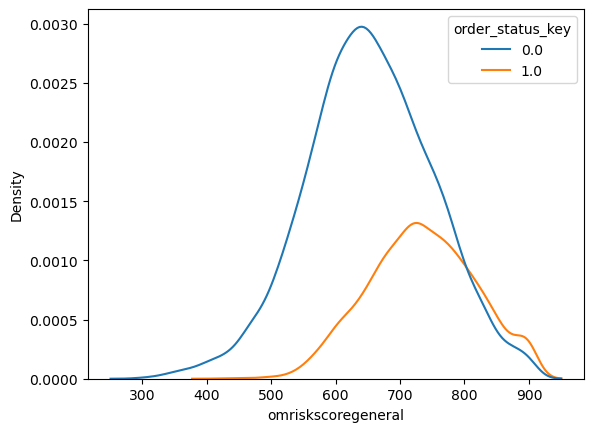

In [67]:
sns.kdeplot(x='omriskscoregeneral', data=shangwei_credit, hue='order_status_key')

## 人口统计学信息

In [92]:
demographic = data[['sample', 'demographic']]
demographic.columns = demographic.columns.get_level_values(1)
demographic['actual_age'] = demographic[['actual_age']].apply(binning)
calc_iv(demographic, 'actual_age', 'order_status_key', False)

/tmp/ipykernel_189066/4276307831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic['actual_age'] = demographic[['actual_age']].apply(binning)


0.115589

In [93]:
calc_iv(demographic, 'gender', 'order_status_key', False)

0.148834

## 调查问卷信息

In [97]:
quest = data[['sample', 'quest']]
quest.columns = quest.columns.get_level_values(1)
quest['degree'] = quest['degree'].fillna('NONE')
calc_iv(quest, 'degree', 'order_status_key', True)

  Variable     Value   All  Good   Bad  Distribution Good  Distribution Bad  \
3   degree      NONE    75     5    70           0.002131          0.009819   
0   degree      大学专科  6863  1923  4940           0.683239          0.683308   
1   degree      大学本科  1254   522   732           0.185724          0.101369   
4   degree  硕士（含）及以上    67    27    40           0.009943          0.005670   
2   degree     高中及以下  1788   339  1449           0.120739          0.200526   

        WoE            IV  
3 -1.527861  1.174643e-02  
0 -0.000101  7.037411e-09  
1  0.605496  5.107678e-02  
4  0.561692  2.400196e-03  
2 -0.507313  4.047695e-02  
IV =  0.1057


/tmp/ipykernel_189066/1655123393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quest['degree'] = quest['degree'].fillna('NONE')


0.1057

In [99]:
quest = data[['sample', 'quest']]
quest.columns = quest.columns.get_level_values(1)
quest['card_num'] = quest['card_num'].fillna('NONE')
calc_iv(quest, 'card_num', 'order_status_key', True)

   Variable  Value   All  Good   Bad  Distribution Good  Distribution Bad  \
0  card_num     1张  3026   869  2157           0.308949          0.298437   
3  card_num     2张  2337   836  1501           0.297230          0.207717   
1  card_num     3张  1240   400   840           0.142401          0.116305   
2  card_num  4张及以上  1108   348   760           0.123935          0.105241   
4  card_num   NONE    79     5    74           0.002131          0.010372   
5  card_num   无信用卡  2257   358  1899           0.127486          0.262758   

        WoE        IV  
0  0.034616  0.000364  
3  0.358331  0.032075  
1  0.202430  0.005283  
2  0.163498  0.003056  
4 -1.582669  0.013043  
5 -0.723227  0.097832  
IV =  0.151654


/tmp/ipykernel_189066/1822462063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quest['card_num'] = quest['card_num'].fillna('NONE')


0.151654

经初步分析，以下产品比较有效：
- 百融多头：有较好的区分效果，但是只覆盖了80%的客户。尽管如此，没覆盖到的客户批核率很高，有38%（客群中核卡率是28%）。
- 百融特殊名单：免费，没有通过黑名单的客户占3.5%左右，而且基本不能通过银行审核，可以用作规则
- 百融偿债压力指数：在偿债压力较高的用户群里（前20%），区分度较高，但是在剩下的客群里区分度不高
- 腾讯反欺诈：反欺诈数据覆盖程度较高，IV也较高，但是相对于百融多头来说召回率没那么高
- 尚为综合信用评估：覆盖率高，区分能力跟腾讯反欺诈差不多
- 因为调查问卷和人口学数据可以免费获取，虽然IV较低，但是加进去对模型也会有一定帮助

在所有特征中，百融多头的近12个非银申请机构数iv最高，根据近12个非银申请机构数是否大于8，能够过滤20%的客户，同时误杀率只有不到1%。  
因此可以先考虑过滤掉百融查不到的，在近12个非银申请机构数大于8的，以及在百融黑名单中客户，再对剩下的客户进行建模。接下来探索一下  
筛选出来的特征在剩下的客户中的重要性。

In [101]:
data2 = data[['sample', 'br_duotou', 'br_black_list', 'br_debt_pressure', 'tc_fraud_risk', 'sw_credit_eval', 'demographic', 'quest']]

In [103]:
interval_feature2 = [('br_duotou', f) for f in interval_feats]
data2[interval_feature2] = data2[interval_feature2].fillna(9999)
data2['br_duotou'] = data2['br_duotou'].fillna(0)

/tmp/ipykernel_189066/3387587060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[interval_feature2] = data2[interval_feature2].fillna(9999)
/tmp/ipykernel_189066/3387587060.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['br_duotou'] = data2['br_duotou'].fillna(0)


In [104]:
filter_cond = (data2[('br_duotou', 'flag_applyloanstr')] == 1) & \
              (data2[('br_duotou', 'als_m12_id_nbank_orgnum')] <= 8) & \
              (data2[('br_black_list', 'flag_specialList_c')] != 1)
data2 = data2[filter_cond]

## 百融多头
根据规则过滤掉一部分样本后，得到进一步过滤一些没有价值的特征

In [72]:
br_duotou2 = data2[['sample', 'br_duotou']]
br_duotou2.columns = br_duotou2.columns.get_level_values(1)
keep_features = ['customer_phone', 'apply_date_key', 'order_status_key'] + br_duotou_qualified_features['feature'].tolist()
br_duotou2 = br_duotou2[keep_features]
br_duotou2.iloc[:, 3:] = br_duotou2.iloc[:, 3:].apply(binning)

In [73]:
br_duotou_iv = []
for c in br_duotou2.iloc[:, 3:].columns:
    br_duotou_iv.append([c, calc_iv(br_duotou2, c, 'order_status_key', False)])
br_duotou_iv = pd.DataFrame(br_duotou_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)
br_duotou_iv

,feature,iv
0,als_m12_id_nbank_orgnum,0.425344
2,als_m12_id_nbank_min_inteday,0.412836
3,als_m12_id_min_inteday,0.364673
1,als_m3_id_nbank_min_inteday,0.355481
4,als_lst_id_nbank_inteday,0.195354
9,als_lst_id_nbank_consnum,0.147418
5,als_m12_id_rel_orgnum,0.096597
10,als_m6_id_bank_min_inteday,0.089939
6,als_m12_id_cooff_orgnum,0.065411
8,als_m12_id_bank_ret_orgnum,0.035026


In [74]:
br_duotou_qualified_features = br_duotou_iv.query("iv >= 0.02")

## 百融偿债压力指数

In [75]:
br_debt_pressure2 = data2[['sample', 'br_debt_pressure']]
br_debt_pressure2.columns = br_debt_pressure2.columns.get_level_values(1)
br_debt_pressure2['drs_nodebtscore'] = br_debt_pressure2[['drs_nodebtscore']].apply(binning)

/tmp/ipykernel_189066/4223384588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br_debt_pressure2['drs_nodebtscore'] = br_debt_pressure2[['drs_nodebtscore']].apply(binning)


In [76]:
calc_iv(br_debt_pressure2, 'drs_nodebtscore', 'order_status_key', False)

0.283395

## 腾讯反欺诈

In [77]:
tc_fraud_risk2 = data2[['sample', 'tc_fraud_risk']]
tc_fraud_risk2.columns = tc_fraud_risk2.columns.get_level_values(1)
tc_fraud_risk2 = tc_fraud_risk2.dropna(subset=['highirr_v6_20220425_score'])
tc_fraud_risk2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6253 entries, 1 to 10045
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_phone                 6253 non-null   object 
 1   apply_date_key                 6253 non-null   object 
 2   order_status_key               6253 non-null   float64
 3   id_found:                      6253 non-null   int64  
 4   found:                         6253 non-null   int64  
 5   risk_score:                    6253 non-null   int64  
 6   risk_code:                     198 non-null    object 
 7   highirr_v6_20220425_score      6253 non-null   float64
 8   lowirr_v6_20220425_score       6253 non-null   float64
 9   tongyong_v6_20220425_score     6253 non-null   float64
 10  model_risk_v7_shighirr_score   6253 non-null   float64
 11  model_risk_v7_slowirr_score    6253 non-null   float64
 12  model_risk_v7_stongyong_score  6253 non-null   

In [78]:
tc_fraud_risk2= tc_fraud_risk2.drop(['risk_code:', 'id_found:', 'found:'], axis=1)

In [79]:
tc_fraud_risk2.iloc[:, 3:] = tc_fraud_risk2.iloc[:, 3:].apply(binning)

In [80]:
tc_fraud_risk_iv = []
for c in tc_fraud_risk2.iloc[:, 3:].columns:
    tc_fraud_risk_iv.append([c, calc_iv(tc_fraud_risk2, c, 'order_status_key', False)])
tc_fraud_risk_iv = pd.DataFrame(tc_fraud_risk_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)
tc_fraud_risk_iv

,feature,iv
6,model_risk_v7_stongyong_score,0.564820
5,model_risk_v7_slowirr_score,0.543284
4,model_risk_v7_shighirr_score,0.494361
2,lowirr_v6_20220425_score,0.443891
3,tongyong_v6_20220425_score,0.433905
1,highirr_v6_20220425_score,0.422496
0,risk_score:,0.298342
7,v6_seq_online,0.229814


In [81]:
iv_threshold = 0.02
tc_fraud_qualified_features = tc_fraud_risk_iv.query(f'iv > {iv_threshold}').reset_index(drop=True)
cursor = -1

discard_features = []
while abs(cursor) < tc_fraud_qualified_features.shape[0]:
    print('number of discard features: ', len(discard_features))
    X = add_constant(tc_fraud_risk2[filter(lambda x: x not in discard_features, tc_fraud_qualified_features['feature'])])
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).rename('vif')
    tc_fraud_qualified_features = tc_fraud_qualified_features.drop(columns=['vif'], errors='ignore').merge(vif, left_on='feature', right_index=True, how="inner")
    feature, iv, vif_val = tc_fraud_qualified_features.iloc[cursor, :].values
    if vif_val < 4:
        cursor = cursor - 1
    else:
        discard_features.append(feature)

number of discard features:  0
number of discard features:  0
number of discard features:  0
number of discard features:  1
number of discard features:  2
number of discard features:  3
number of discard features:  4
number of discard features:  5


In [82]:
tc_fraud_qualified_features

,feature,iv,vif
0,model_risk_v7_stongyong_score,0.564820,1.903498
6,risk_score:,0.298342,1.673558
7,v6_seq_online,0.229814,1.332896


## 尚为综合信用评估

In [83]:
sw_credit2 = data2[['sample', 'sw_credit_eval']]
sw_credit2.columns = sw_credit2.columns.get_level_values(1)
sw_credit2 = sw_credit2.query('y == "y"')
sw_credit2['omriskscoregeneral'] = sw_credit2[['omriskscoregeneral']].apply(binning)
calc_iv(sw_credit2, 'omriskscoregeneral', 'order_status_key', False)

0.487268

## 人口统计信息

In [105]:
demographic2 = data2[['sample', 'demographic']]
demographic2.columns = demographic2.columns.get_level_values(1)
demographic2['actual_age'] = demographic2[['actual_age']].apply(binning)
calc_iv(demographic2, 'actual_age', 'order_status_key', False)

/tmp/ipykernel_189066/1348797953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic2['actual_age'] = demographic2[['actual_age']].apply(binning)


0.095221

In [106]:
calc_iv(demographic2, 'gender', 'order_status_key', False)

0.100927

## 调查问卷数据

In [107]:
quest2 = data2[['sample', 'quest']]
quest2.columns = quest2.columns.get_level_values(1)
quest2['degree'] = quest2['degree'].fillna('NONE')
calc_iv(quest2, 'degree', 'order_status_key', True)

  Variable     Value   All  Good   Bad  Distribution Good  Distribution Bad  \
3   degree      NONE    48     2    46           0.001469          0.011111   
1   degree      大学专科  4351  1421  2930           0.696376          0.692908   
0   degree      大学本科   808   360   448           0.176787          0.106147   
4   degree  硕士（含）及以上    43    19    24           0.009794          0.005910   
2   degree     高中及以下  1022   240   782           0.118022          0.185106   

        WoE        IV  
3 -2.023263  0.019508  
1  0.004993  0.000017  
0  0.510127  0.036036  
4  0.505129  0.001962  
2 -0.450063  0.030192  
IV =  0.087716


/tmp/ipykernel_189066/3983956311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quest2['degree'] = quest2['degree'].fillna('NONE')


0.087716

In [108]:
quest2 = data2[['sample', 'quest']]
quest2.columns = quest2.columns.get_level_values(1)
quest2['card_num'] = quest2['card_num'].fillna('NONE')
calc_iv(quest2, 'card_num', 'order_status_key', True)

   Variable  Value   All  Good   Bad  Distribution Good  Distribution Bad  \
1  card_num     1张  1782   588  1194           0.288443          0.282506   
3  card_num     2张  1548   624   924           0.306072          0.218676   
0  card_num     3张   870   312   558           0.153281          0.132151   
2  card_num  4张及以上   806   283   523           0.139079          0.123877   
4  card_num   NONE    50     2    48           0.001469          0.011584   
5  card_num   无信用卡  1216   233   983           0.114594          0.232624   

        WoE        IV  
1  0.020797  0.000123  
3  0.336230  0.029385  
0  0.148326  0.003134  
2  0.115755  0.001760  
4 -2.064936  0.020886  
5 -0.708033  0.083569  
IV =  0.138858


/tmp/ipykernel_189066/521172759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quest2['card_num'] = quest2['card_num'].fillna('NONE')


0.138858

## 最后选用特征

In [110]:
selected_features = br_duotou_qualified_features.feature.tolist() \
                    + ['flag_applyloanstr'] \
                    + ['flag_specialList_c'] \
                    + tc_fraud_qualified_features.feature.tolist() \
                    + ['omriskscoregeneral'] \
                    + ['actual_age', 'gender'] \
                    + ['degree', 'card_num']

In [111]:
pickle.dump(selected_features, open(config.SELECTED_FEATURES, "wb"))

## 总结
经过前筛后剩下6200多条数据（约60%，也就是模型会应用于60%的客户身上），百融多头能够进一步过滤一些特征。
腾讯反欺诈排除掉高vif的特征后，还有3个特征有比较高的iv，其中model_risk_v7_stongyong_score超过了0.5，
尚为综合信用评估的iv也不错。

经过一系列分析，最终选择一下特征入模：  
百融多头：  
- 'als_m12_id_nbank_orgnum',  
- 'als_m12_id_nbank_min_inteday',
- 'als_m12_id_min_inteday',
- 'als_m3_id_nbank_min_inteday',
- 'als_lst_id_nbank_inteday',
- 'als_lst_id_nbank_consnum',
- 'als_m12_id_rel_orgnum',
- 'als_m6_id_bank_min_inteday',
- 'als_m12_id_cooff_orgnum',
- 'als_m12_id_bank_ret_orgnum',
- 'als_m12_id_bank_week_orgnum',
- 'als_m12_id_af_allnum',
- 'als_d7_id_rel_allnum',
- als_m12_id_nbank_night_orgnum',
- 'als_d7_id_nbank_week_orgnum'  

腾讯反欺诈：  
- model_risk_v7_stongyong_score
- risk_score:
- v6_seq_online  

尚为综合信用评估：
- omriskscoregeneral

人口学数据：
- gender
- actual_age

调查问卷数据:
- degree
- card_num